In [82]:
import json
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from itertools import product
from collections import Counter
import networkx as nx
import random
from wordcloud import WordCloud
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

The text used for the text analysis were collected from web-scraping description of products of the [BilkaToGo](https://www.bilkatogo.dk/) website. The descriptions are a small text about a certain procuts typically explaining what the product tastes like, and what occasions/setting they are typically enjoyed in.  The website is tied to a database and the structure is heavily based on Javascript making the web-scraping a tideous and long process. However, with the help of the 'sellenium' python package, which interacts with the website, we were then able to webscrape the relevant text data. By looking at the website structure, we understood that the products are divided into categories e.g. 'Frugt og Grønt', 'Kød' etc. so we could control which products we would like to include in the analysis. This project focuses only on categories regarding food products.
Some products also have a description regarding the brand of the products which we leave out of the data-collection. 

These description vary a lot in length, from the shortest description length of just 1 word about [this wine bottle](https://www.bilkatogo.dk/produkt/montgras-ninquen/33560/) with just '.' when cleaning about the brand description and the longest description length of 325 words about [this bottle of rum](https://www.bilkatogo.dk/produkt/plantation-gylden-rom-double-aged-grande-reserve/72126/). 
The average word length of the descriptions are 57.56 words with a standard deviation of 17.55 and a median of 55. And if we take a look of the distribution of the word length of the product descriptions, we can see that it is normally distributed.

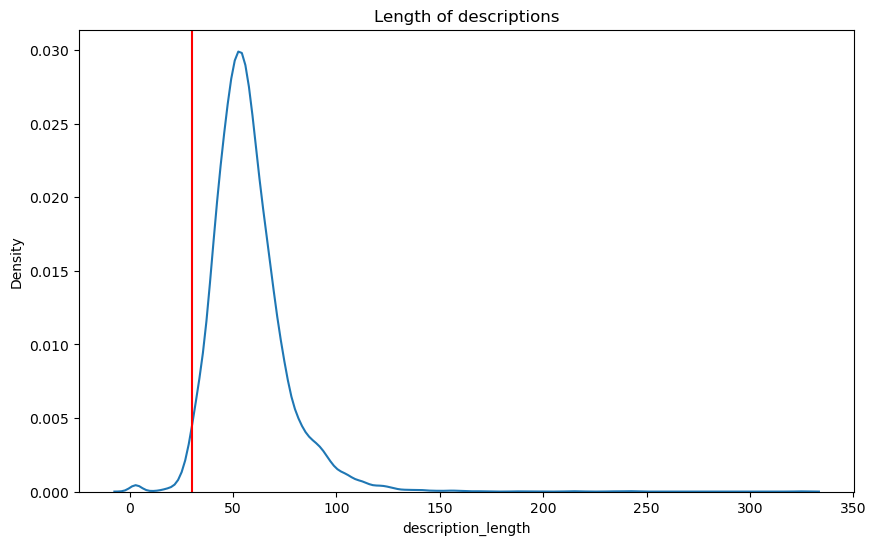

In order to adress the problem that very short descriptions like the one of the 1 word description of a wine bottle doesn't contain a lot of information of the product and is not usefull in a text analysis, we introduce a cut-off threshold. We introduce this threshold to ensure that only products with description longer than this threshold is included. 
The threshold is decided as a cut-off of the low end tail of the normal distribution at ≤30.  

When cutting of products with a product description of less that 30 words, 149 products are cut off from the data. This cut-off means that the new mean of the description lengths are 58.12 words with a standard deviation of 17.05 and median of 55.

When working with text analysis tools it is essential that we tokenize the text, such that we break the text into more managable pieces for NLP applications. This is done with nltk python package that can remove unwanted tokens such as danish stop words, punctuation etc. 
The distribution of the tokenized text can be seem below

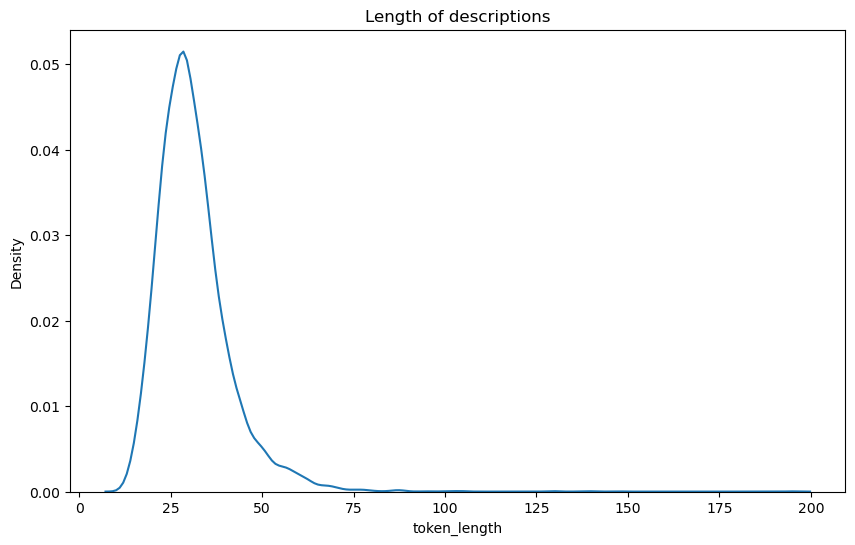

We note that it still has the same shape as a normal distribution. This distribution of tokenized descriptions has a mean of 31.28 a standard deviation of 10.03 and a median of 30. Which means that with tokenizing the text, the mean  of the desription length decreased by 27.

With this analysis, we would like to get an insight in the consumer buying patterns and we could get this insight by analysing the the words that characterize certain natural communities within the frequently-bought-together network. Here, we might get som insight in what makes products frequently bought together. In order to do this, we use the TF-IDF scores on the tokenized product descriptions.
These TF-IDF scores of words help us identify what words specifically are unique for each community.
The TF-IDF scores of words for the top 9 communities can be seen below:

<span style="color:red">Indsæt et table med top ord her </span>

We see some different patterns that we can associate from each other in each communities. We some clear ones in e.g. community 2 that has ecology, and community 3 which has a lot of top words that can make this community be interperated like a candy-like community with top words like 'enjoy', 'liquorice', 'milk-chocolate' etc. But to get a better overview of the top words within each community, let's look at the top TF-IDF words in word clouds for the top 9 communities:

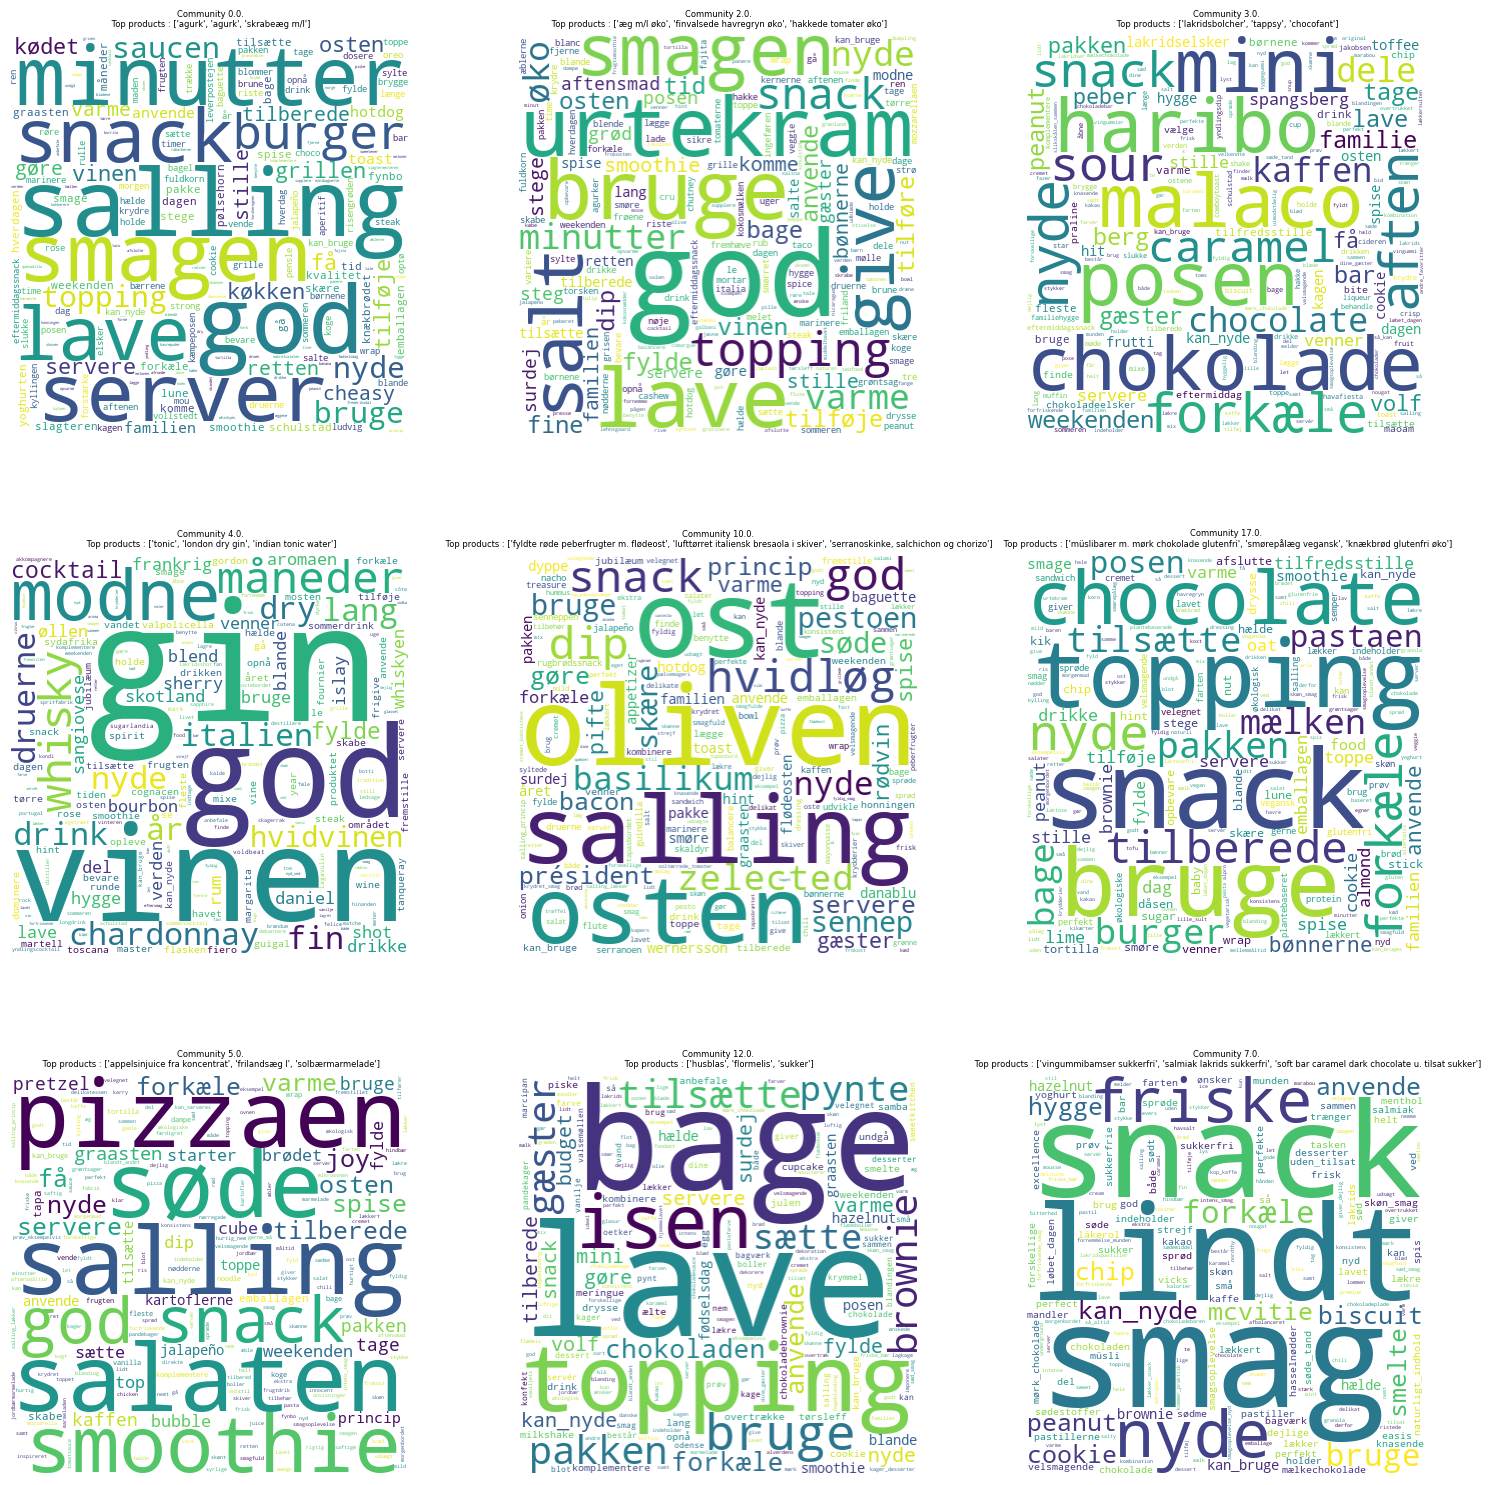

<span style="color:red"> Indsæt noget text til hver community </span>

<span style="color:red"> Finde noget mere analyse der kunne være fedt?
evt. 

 </span>

In [83]:
data_clean = pd.read_csv('data/df_clean_data_with_comm_degree.csv', sep=";")

In [84]:
#load the CSS-network that was created in assignment 1
def load_network_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        G = nx.node_link_graph(data)
    return G

file_path = 'data/network_with_attributes.json'
G = load_network_from_json(file_path)


print(f'The number of nodes in G is {G.number_of_nodes()} and the amount of edges are {G.number_of_edges()}')
print(f'The denisty of G is {nx.density(G)}')
print(f'Is the graph fully connected: {nx.is_connected(G)}')

The number of nodes in G is 9324 and the amount of edges are 286791
The denisty of G is 0.006598383676577391
Is the graph fully connected: True


In [85]:
import nltk

In [86]:
N = G.number_of_nodes() #8478
L = G.number_of_edges() #23778

p = 2*L/(N*(N-1)) 

#calculate the average degree using p
k = p*(N-1)
print(f'The probability of a link between two nodes is: {p}')
print(f'Average degree of the CSS-network: {k}')

The probability of a link between two nodes is: 0.006598383676577391
Average degree of the CSS-network: 61.516731016731015


In [87]:
def preprocess_text(tokens):
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    stop_words = set(stopwords.words('danish'))


    tokens = [w.lower() for w in tokens if w.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    #tokens = [porter.stem(word=t, to_lowercase=False) for t in tokens]
    
    
    tokens = [token for token in tokens if token.strip()]
    
    
    return tokens

In [88]:
from nltk.tokenize import word_tokenize, sent_tokenize

data_clean['Tokens'] = data_clean['descriptions'].apply(word_tokenize).apply(preprocess_text)
token_list = data_clean['Tokens']
token_list

0       [bananer, anelse, syrlig, mild, sød, smag, not...
1       [peberfrugter, sød, syrlig, smag, hints, stjer...
2       [agurker, smager, mildt, sødt, anelse, syrligt...
3       [bananer, anelse, syrlig, mild, sød, smag, not...
4       [gulerødder, sød, frugtig, mild, anelse, bitte...
                              ...                        
9752    [disko, bay, ekstra, store, kutterrejer, royal...
9753    [oh, my, banofee, pie, ben, jerry, s, lækker, ...
9754    [ice, pops, easis, små, uden, tilsat, sukker, ...
9755    [peanut, butter, cup, ben, jerry, s, cremet, i...
9756    [stegt, halv, kylling, xxl, stor, pakke, dybfr...
Name: Tokens, Length: 9757, dtype: object

In [89]:
data_clean['token_length'] = data_clean['Tokens'].apply(len)


In [90]:
data_clean

,product_id,name,price,link,category,price_amount,unit,outer_category,neighbor_products_id,descriptions,description_length,eco,pairs,community,degree,Tokens,token_length
0,18381,bananer,"2,75/Stk.",/produkt/bananer/18381/,frugt-og-groent,2.75,Stk.,Foods,"[18364, 18379, 19721, 29439, 41701, 50998, 510...","bananer har en anelse syrlig, mild og sød smag...",89.0,False,"[(18381, 18364), (18381, 18379), (18381, 19721...",0.0,166,"[bananer, anelse, syrlig, mild, sød, smag, not...",47
1,51061,peberfrugter røde,"7,25/Stk.",/produkt/peberfrugter-roede/51061/,frugt-og-groent,7.25,Stk.,Foods,"[18323, 18359, 18364, 18381, 18518, 29439, 533...",peberfrugter har en sød og syrlig smag med hin...,88.0,False,"[(51061, 18323), (51061, 18359), (51061, 18364...",0.0,178,"[peberfrugter, sød, syrlig, smag, hints, stjer...",45
2,61090,agurk øko,"9,00/Stk.",/produkt/salling-oeko-agurk-oeko/61090/,frugt-og-groent,9.00,Stk.,Foods,"[19676, 19687, 37982, 39411, 41388, 51061, 694...","agurker smager mildt, sødt, en anelse syrligt ...",95.0,True,"[(61090, 19676), (61090, 19687), (61090, 37982...",0.0,156,"[agurker, smager, mildt, sødt, anelse, syrligt...",54
3,72008,bananer 4 pak øko,"2,20/Stk.",/produkt/bananer-4-pak-oeko/72008/,frugt-og-groent,2.20,Stk.,Foods,"[18364, 19676, 19687, 29439, 37982, 39411, 404...","bananer har en anelse syrlig, mild og sød smag...",89.0,True,"[(72008, 18364), (72008, 19676), (72008, 19687...",0.0,129,"[bananer, anelse, syrlig, mild, sød, smag, not...",47
4,18323,gulerødder,"10,00/Kg.",/produkt/salling-guleroedder/18323/,frugt-og-groent,10.00,Kg.,Foods,"[18330, 18364, 18381, 29439, 41688, 51061, 533...","gulerødder har en sød, frugtig, mild og en ane...",70.0,False,"[(18323, 18330), (18323, 18364), (18323, 18381...",0.0,70,"[gulerødder, sød, frugtig, mild, anelse, bitte...",38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9752,31480,grønlandske rejer str. xl,"279,60/Kg.",/produkt/royal-greenland-groenlandske-rejer-st...,frost,279.60,Kg.,Foods,"[18033, 20964, 39244, 41390, 64851, 65011, 838...",disko bay ekstra store kutterrejer fra royal g...,98.0,False,"[(31480, 18033), (31480, 20964), (31480, 39244...",2.0,13,"[disko, bay, ekstra, store, kutterrejer, royal...",64
9753,91190,"flødeis m. banan, chokoladestykker og karamel","175,53/L.",/produkt/ben-og-jerrys-floedeis-m-banan-chokol...,frost,175.53,L.,Foods,"[75584, 75586, 75588, 75592, 75593, 75595, 911...",oh my! banofee pie! fra ben & jerry’s er en læ...,69.0,False,"[(91190, 75584), (91190, 75586), (91190, 75588...",3.0,11,"[oh, my, banofee, pie, ben, jerry, s, lækker, ...",40
9754,85175,"frys-selv-is m. jordbær-, appelsin-, citron- o...","47,16/Kg.",/produkt/easis-frys-selv-is-m-jordbaer-appelsi...,frost,47.16,Kg.,Foods,"[42710, 89820, 90818, 104708, 106902, 117116, ...",ice pops fra easis er små frys-selv-is uden ti...,50.0,False,"[(85175, 42710), (85175, 89820), (85175, 90818...",7.0,13,"[ice, pops, easis, små, uden, tilsat, sukker, ...",29
9755,75592,flødeis m. peanutbutter,"161,18/L.",/produkt/ben-og-jerrys-floedeis-m-peanutbutter...,frost,161.18,L.,Foods,"[66008, 75584, 75586, 75593, 91190, 91196, 112...",peanut butter cup fra ben & jerry’s er en crem...,61.0,False,"[(75592, 66008), (75592, 75584), (75592, 75586...",3.0,11,"[peanut, butter, cup, ben, jerry, s, cremet, i...",35


In [91]:
data_clean.describe()

,product_id,price_amount,description_length,community,degree,token_length
count,9757.000000,9757.000000,9757.000000,9755.000000,9757.000000,9757.000000
mean,76928.596392,140.941703,58.116532,6.752537,15.205493,33.608281
std,34677.785903,140.459136,17.051650,6.709844,9.749533,10.223421
min,14532.000000,0.020000,30.000000,0.000000,0.000000,14.000000
25%,51050.000000,50.000000,47.000000,2.000000,10.000000,27.000000
50%,81648.000000,102.670000,55.000000,4.000000,13.000000,32.000000
75%,108349.000000,178.570000,66.000000,12.000000,17.000000,38.000000
max,133516.000000,998.570000,325.000000,23.000000,394.000000,197.000000


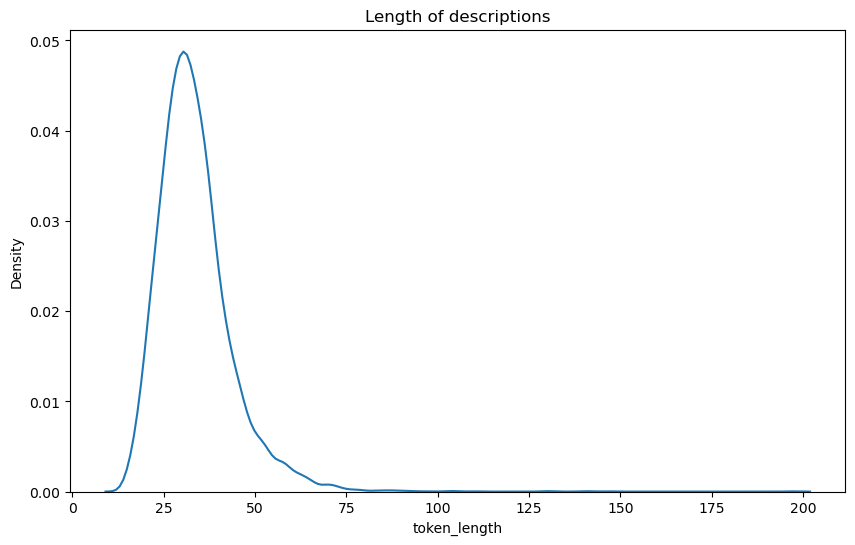

In [92]:
#plot the length of the descriptions for the products
plt.figure(figsize=(10,6))
sns.kdeplot(data_clean['token_length'])
plt.title('Length of descriptions')
plt.show()

In [93]:
from itertools import chain
comprehensive_token_list = list(chain(*[token_list[idx] for idx in token_list.index]))

In [94]:
from collections import Counter
def sort_by_most_appearing(strings):
    # Count occurrences of each string
    counts = Counter(strings)
    
    # Sort the list based on the counts
    sorted_strings = sorted(strings, key=lambda x: counts[x], reverse=True)
    
    return sorted_strings
sorted_comprehensive_token_list = sort_by_most_appearing(comprehensive_token_list)

In [95]:
from tqdm import tqdm
amount_of_words = len(Counter(comprehensive_token_list).most_common())
word_count_list = Counter(comprehensive_token_list).most_common()
word_count = [word_count_list[i][1] for i in tqdm(range(amount_of_words))]

100%|██████████| 19391/19391 [00:00<00:00, 7267603.33it/s]


In [96]:
def plot_frequency_rank(word_count, amount_of_words):
    # Sort the words based on their frequencies
    
    
    # Get ranks and frequencies
    ranks = list(range(1, amount_of_words + 1))
    frequencies = word_count
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, frequencies, marker='o', linestyle='-')
    plt.title('Frequency-Rank Plot')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.xscale('log')  # Use logarithmic scale for better visualization
    plt.yscale('log')
    plt.grid(True)
    plt.show()


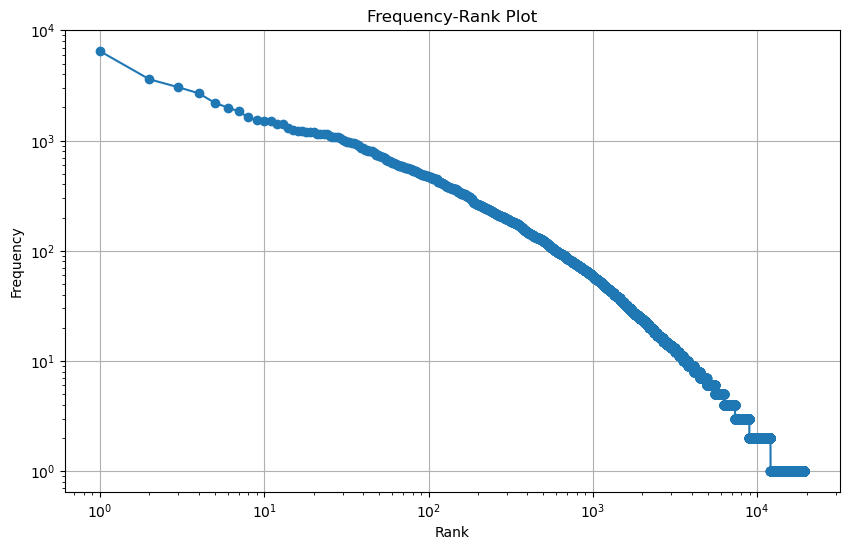

In [97]:
plot_frequency_rank(word_count, amount_of_words)

In [98]:
from nltk import bigrams
descriptions_bigrams = list(chain(*[list(bigrams(token_list[i])) for i in token_list.index]))

In [99]:
import numpy as np
from nltk import FreqDist
from tqdm import tqdm

def analyze_bigrams(bigrams):
    unique_bigrams = {}
    
    other_bigrams = len(bigrams)
    word1_list = [0 for _ in range(len(bigrams))]
    word2_list = [0 for _ in range(len(bigrams))]

    for idx, bigram in tqdm(enumerate(bigrams)):
        word1, word2 = bigram
        if bigram in unique_bigrams:
            unique_bigrams[bigram]['nii'] += 1
        else:
            unique_bigrams[bigram] = {'nii':1}
        
        word1_list[idx] = word1
        word2_list[idx] = word2

    fdist1 = dict(FreqDist(word1_list).most_common())
    fdist2 = dict(FreqDist(word2_list).most_common())
    contingency_tables = {}
    Expected_tables = {}
    
    for bigram in bigrams:
        bw1, bw2 = bigram
        unique_bigrams[bigram]['nio'] = fdist1[str(bw1)] - unique_bigrams[bigram]['nii']
        unique_bigrams[bigram]['noi'] = fdist2[str(bw2)] - unique_bigrams[bigram]['nii']
        unique_bigrams[bigram]['noo'] = other_bigrams - fdist1[str(bw1)] - fdist2[str(bw2)]
        
        nii = unique_bigrams[bigram]['nii']
        nio = unique_bigrams[bigram]['nio']
        noi = unique_bigrams[bigram]['noi']
        noo = unique_bigrams[bigram]['noo']
        contingency_tables[bigram] = np.array([[nii, nio], [noi, noo]])


    # Create contingency table for each bigram
    
    
        R1 = nii + nio
        C1 = nii + noi
        R2 = noi + noo
        C2 = nio + noo
        N = other_bigrams
        
        Expected_tables[bigram] = np.array([[R1*C1/N,R1*C2/N],[R2*C1/N,R2*C2/N]])
        
    #Create expected contingency table for each bigram
    

    return contingency_tables, Expected_tables

# Example usage:
contingency, expected = analyze_bigrams(descriptions_bigrams)


318159it [00:00, 2268849.45it/s]


In [100]:
Chi2 = {}
p_value = {}
import scipy
for bigram in set(descriptions_bigrams):
    O = contingency[bigram]
    E = expected[bigram]
    #Chi2[bigram] = scipy.stats.chisquare(O,E
    Chi2[bigram] = np.sum(np.square(O-E)/E)
    p_value[bigram] = scipy.stats.chi2.sf(Chi2[bigram],df=1)
    

In [101]:
fdist_bigram = dict(FreqDist(descriptions_bigrams).most_common())
fdist_bigram = {key:val for key, val in fdist_bigram.items() if val >= 50}
collocations = [key for key,val in fdist_bigram.items() if p_value[key] < 0.001]
collocations

[('dine', 'gæster'),
 ('blandt', 'andet'),
 ('kan', 'bruges'),
 ('kan', 'nydes'),
 ('salling', 'øko'),
 ('prøv', 'eksempel'),
 ('kop', 'kaffe'),
 ('løbet', 'dagen'),
 ('skøn', 'smag'),
 ('prøv', 'eksempelvis'),
 ('hele', 'familien'),
 ('salling', 'princip'),
 ('dejlig', 'smag'),
 ('søde', 'tand'),
 ('sød', 'smag'),
 ('fyldig', 'smag'),
 ('mild', 'smag'),
 ('santa', 'maria'),
 ('cremet', 'konsistens'),
 ('mørk', 'chokolade'),
 ('krydret', 'smag'),
 ('prøv', 'bruge'),
 ('kan', 'både'),
 ('passer', 'perfekt'),
 ('intens', 'smag'),
 ('varm', 'sommerdag'),
 ('gode', 'smag'),
 ('salling', 'lækker'),
 ('særdeles', 'velegnet'),
 ('god', 'smag'),
 ('kan', 'fordel'),
 ('syrlig', 'smag'),
 ('lidt', 'ekstra'),
 ('frisk', 'smag'),
 ('kan', 'anvendes'),
 ('så', 'kan'),
 ('lækker', 'snack'),
 ('store', 'små'),
 ('creme', 'fraiche'),
 ('frisk', 'salat'),
 ('lille', 'sult'),
 ('tilsat', 'sukker'),
 ('alverdens', 'retter'),
 ('forfriskende', 'smag'),
 ('aromatisk', 'smag'),
 ('hvilket', 'giver'),
 ('kan

In [102]:
from nltk.tokenize import MWETokenizer
tokenizer = MWETokenizer(collocations)

In [103]:
data_clean['Tokens']=data_clean['Tokens'].apply(tokenizer.tokenize)
data_clean['Tokens'][1]


['peberfrugter',
 'sød',
 'syrlig_smag',
 'hints',
 'stjernefrugt',
 'citrus',
 'sød',
 'skarp',
 'duft',
 'græsgrønne',
 'gode',
 'ostemad',
 'smørrebrød',
 'salater',
 'velegnede',
 'tilberedning',
 'eksempel',
 'grillet',
 'flået',
 'lagt',
 'krydret',
 'olie',
 'grundingrediens',
 'pesto',
 'prøv',
 'salsa',
 'basisgrøntsag',
 'smagfuld',
 'ideelle',
 'opbevaringstemperatur',
 'grader',
 'køleskab',
 'tag',
 'peberfrugter',
 'times',
 'tid',
 'før',
 'brug',
 'smag',
 'duft',
 'derved',
 'træder',
 'tydeligere',
 'frem']

In [104]:
data_clean.to_csv('data/descriptions_TOKENIZED_STEMMED.csv',index=False, sep=";")

In [105]:
# Define a function to extract tokens and concatenate them for each community
def concatenate_tokens(group):
    tokens_list = group['Tokens'].explode().tolist() #should be list of strings
    return tokens_list


# Group by community and apply the function to concatenate tokens
community_tokens = data_clean.groupby('community').apply(concatenate_tokens)


# Reset index to convert the groupby result back to a DataFrame
community_tokens = community_tokens.reset_index(name='Tokens')

community_tokens.head()

/var/folders/vg/smyn0xpj4txbs4bxknnvc4zw0000gn/T/ipykernel_47964/3678766654.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_tokens = data_clean.groupby('community').apply(concatenate_tokens)


,community,Tokens
0,0.0,"[bananer, anelse, syrlig, mild, sød_smag, note..."
1,1.0,"[mesterhakket, grisekød, hakket, grisekød, bed..."
2,2.0,"[squash, smager, mildt, lidt, sødt, agurk, min..."
3,3.0,"[kalkunbrystfilet, magert, mild_smag, kalkunbr..."
4,4.0,"[limesaft, både, smager, dufter, syrligt, fris..."


In [106]:
#print some insights
for i in range(10):
    c = community_tokens['community'][i]
    print(f"for community {c} we have the following number of tokens: {len(community_tokens['Tokens'][i])}")


for community 0.0 we have the following number of tokens: 55034
for community 1.0 we have the following number of tokens: 7757
for community 2.0 we have the following number of tokens: 50677
for community 3.0 we have the following number of tokens: 28893
for community 4.0 we have the following number of tokens: 33021
for community 5.0 we have the following number of tokens: 13877
for community 6.0 we have the following number of tokens: 5549
for community 7.0 we have the following number of tokens: 7230
for community 8.0 we have the following number of tokens: 1516
for community 9.0 we have the following number of tokens: 6154


In [107]:
#the top 5 communities
top_5_communities = data_clean['community'].value_counts().nlargest(5).index.tolist()

#for each top 5 community, print the top 5 most common tokens
for community in top_5_communities:
    print("-----------------------------------------------------------------------")
    print(f"Community {community}")
    print("-----------------------------------------------------------------------")
    tokens = community_tokens["Tokens"][community_tokens["community"] == community].explode().tolist()
    tokens_series = pd.Series(tokens)
    print(f"The top 5 most common tokens in community {community} by the TF are:")
    print(tokens_series.value_counts().nlargest(5)/len(tokens_series)) # Normalized by the total number of tokens in the community
    print("\n")

-----------------------------------------------------------------------
Community 0.0
-----------------------------------------------------------------------
The top 5 most common tokens in community 0.0 by the TF are:
salling    0.009049
smag       0.007450
lækker     0.006905
nyd        0.006887
kan        0.005033
Name: count, dtype: float64


-----------------------------------------------------------------------
Community 2.0
-----------------------------------------------------------------------
The top 5 most common tokens in community 2.0 by the TF are:
økologisk      0.014089
smag           0.007716
økologiske     0.007025
brug           0.006334
salling_øko    0.006236
Name: count, dtype: float64


-----------------------------------------------------------------------
Community 3.0
-----------------------------------------------------------------------
The top 5 most common tokens in community 3.0 by the TF are:
nyd               0.011041
lakrids           0.008480
mælkechok

In [108]:
idf_scores = {}
for c in top_5_communities: # Loop over 5 largest communities
    #Get all Work-ids for the works written by community members
    Works = list(data_clean.loc[data_clean["community"] == c, "product_id"])  

    # Retrieve all tokens used throughout the abstracts tied to authors from the community
    community_tokens = []
    token_doc_frequency = Counter()
    for idx, work in enumerate(Works):

        tokens = list(data_clean.loc[data_clean["product_id"] == work, "Tokens"])[0]
        token_doc_frequency.update(set(tokens))
    

    # Calculate IDF score based on the df of the individual tokens 
    idf_scores[c] = {}
    for token, freq in token_doc_frequency.items():
        idf_scores[c][token] = np.log(len(Works) / freq)

# Plot the top 5 IDF words along with their score for each community
for c in top_5_communities:
    print("-----------------------------------------------------------------------")
    print("Community:", c)
    print("-----------------------------------------------------------------------")
    print(f"The top 5 tokens in community {c} by the IDF are:")
    top_idf_scores = sorted(idf_scores[c].items(), key=lambda x: x[1], reverse=True)[:5]
    
    for token, score in top_idf_scores:
        data = [token, score]
        print('{:<12s}{:>15.7f}'.format(data[0],data[1]))
    print("\n")


-----------------------------------------------------------------------
Community: 0.0
-----------------------------------------------------------------------
The top 5 tokens in community 0.0 by the IDF are:
basisgrøntsag      7.4633630
flået             7.4633630
grundingrediens      7.4633630
græsgrønne        7.4633630
skindets          7.4633630


-----------------------------------------------------------------------
Community: 2.0
-----------------------------------------------------------------------
The top 5 tokens in community 2.0 by the IDF are:
græsagtigt        7.3601040
cherry            7.3601040
basisgrøntsag      7.3601040
sæsonen           7.3601040
flået             7.3601040


-----------------------------------------------------------------------
Community: 3.0
-----------------------------------------------------------------------
The top 5 tokens in community 3.0 by the IDF are:
kalkunen          6.9275579
magert            6.9275579
kalkunbrystfilet      6.9275

In [109]:
Top_9_communities = list(data_clean['community'].value_counts().nlargest(9).index)
TF_IDF = {}
data_product = pd.read_csv('data/df_clean_data_with_comm_degree.csv', sep=";")
TF = {}
top_authors = {}

for c in Top_9_communities:
    #Calculate token frequency within a community.
    Works = list(data_clean.loc[data_clean["community"] == c, "product_id"])

    token_doc_frequency = Counter()
    token_term_frequency = Counter()
    for idx, work in enumerate(Works):
        tokens = list(data_clean.loc[data_clean["product_id"] == work, "Tokens"])[0]
        token_doc_frequency.update(set(tokens))
        token_term_frequency.update(tokens)
        

    # Calculate IDF and TF-IDF scores for the top 9 largest communities
    TF_IDF[c] = {}
    TF[c] = {}
    for token, freq  in token_term_frequency.items():
        TF[c][token] = freq / token_term_frequency.total()
    
    for token, freq  in token_doc_frequency.items():
        idf = np.log(idx / freq)
        TF_IDF[c][token] = TF[c][token] * idf
        
    # Top 10 TF words in the community
    top_tf_scores = sorted(TF[c].items(), key=lambda x: x[1], reverse=True)[:10]
    print("-----------------------------------------------------------------------")
    print("Community", c, "top 10 TF words:")
    print("-----------------------------------------------------------------------")
    for token, score in top_tf_scores:
        print(token, score)
    #print("-----------------------------------------------------------------------")
    
    # Top 10 TF-IDF words in the community
    top_TF_IDF = sorted(TF_IDF[c].items(), key=lambda x: x[1], reverse=True)[:10]
    print("-----------------------------------------------------------------------")
    print("Community", c, "top 10 TF-IDF words:")
    print("-----------------------------------------------------------------------")
    for token, score in top_TF_IDF:
        print(token, score)
    

    #Top 3 authors within community
    authors = data_product.loc[data_product['community']==c].sort_values(by=['degree'], ascending = False)
    
    top_authors[c] = authors.product_id.unique()[:3]
    print("-----------------------------------------------------------------------")
    print(f'Top 3 authors in this community {c} is :')
    print("-----------------------------------------------------------------------")
    print([list(data_product.loc[data_product['product_id']==top_authors[c][i]].name)[0] for i in range(3)])
    print('\n')
    
    

-----------------------------------------------------------------------
Community 0.0 top 10 TF words:
-----------------------------------------------------------------------
salling 0.009048951557219173
smag 0.007449940037067994
lækker 0.006904822473380093
nyd 0.006886651887923829
brug 0.005033252171384962
kan 0.005033252171384962
sammen 0.004887887487734855
velsmagende 0.004851546316822328
lidt 0.004506305193153324
frisk 0.004360940509503216
-----------------------------------------------------------------------
Community 0.0 top 10 TF-IDF words:
-----------------------------------------------------------------------
salling 0.01212827672444734
smag 0.01158246810862089
lækker 0.011081245795563029
nyd 0.010522080723180107
kan 0.009976661969646338
lidt 0.009577029968244362
sammen 0.009508584769323368
brug 0.009440068289173584
frisk 0.009331449699926764
velsmagende 0.009209538762836873
-----------------------------------------------------------------------
Top 3 authors in this communit

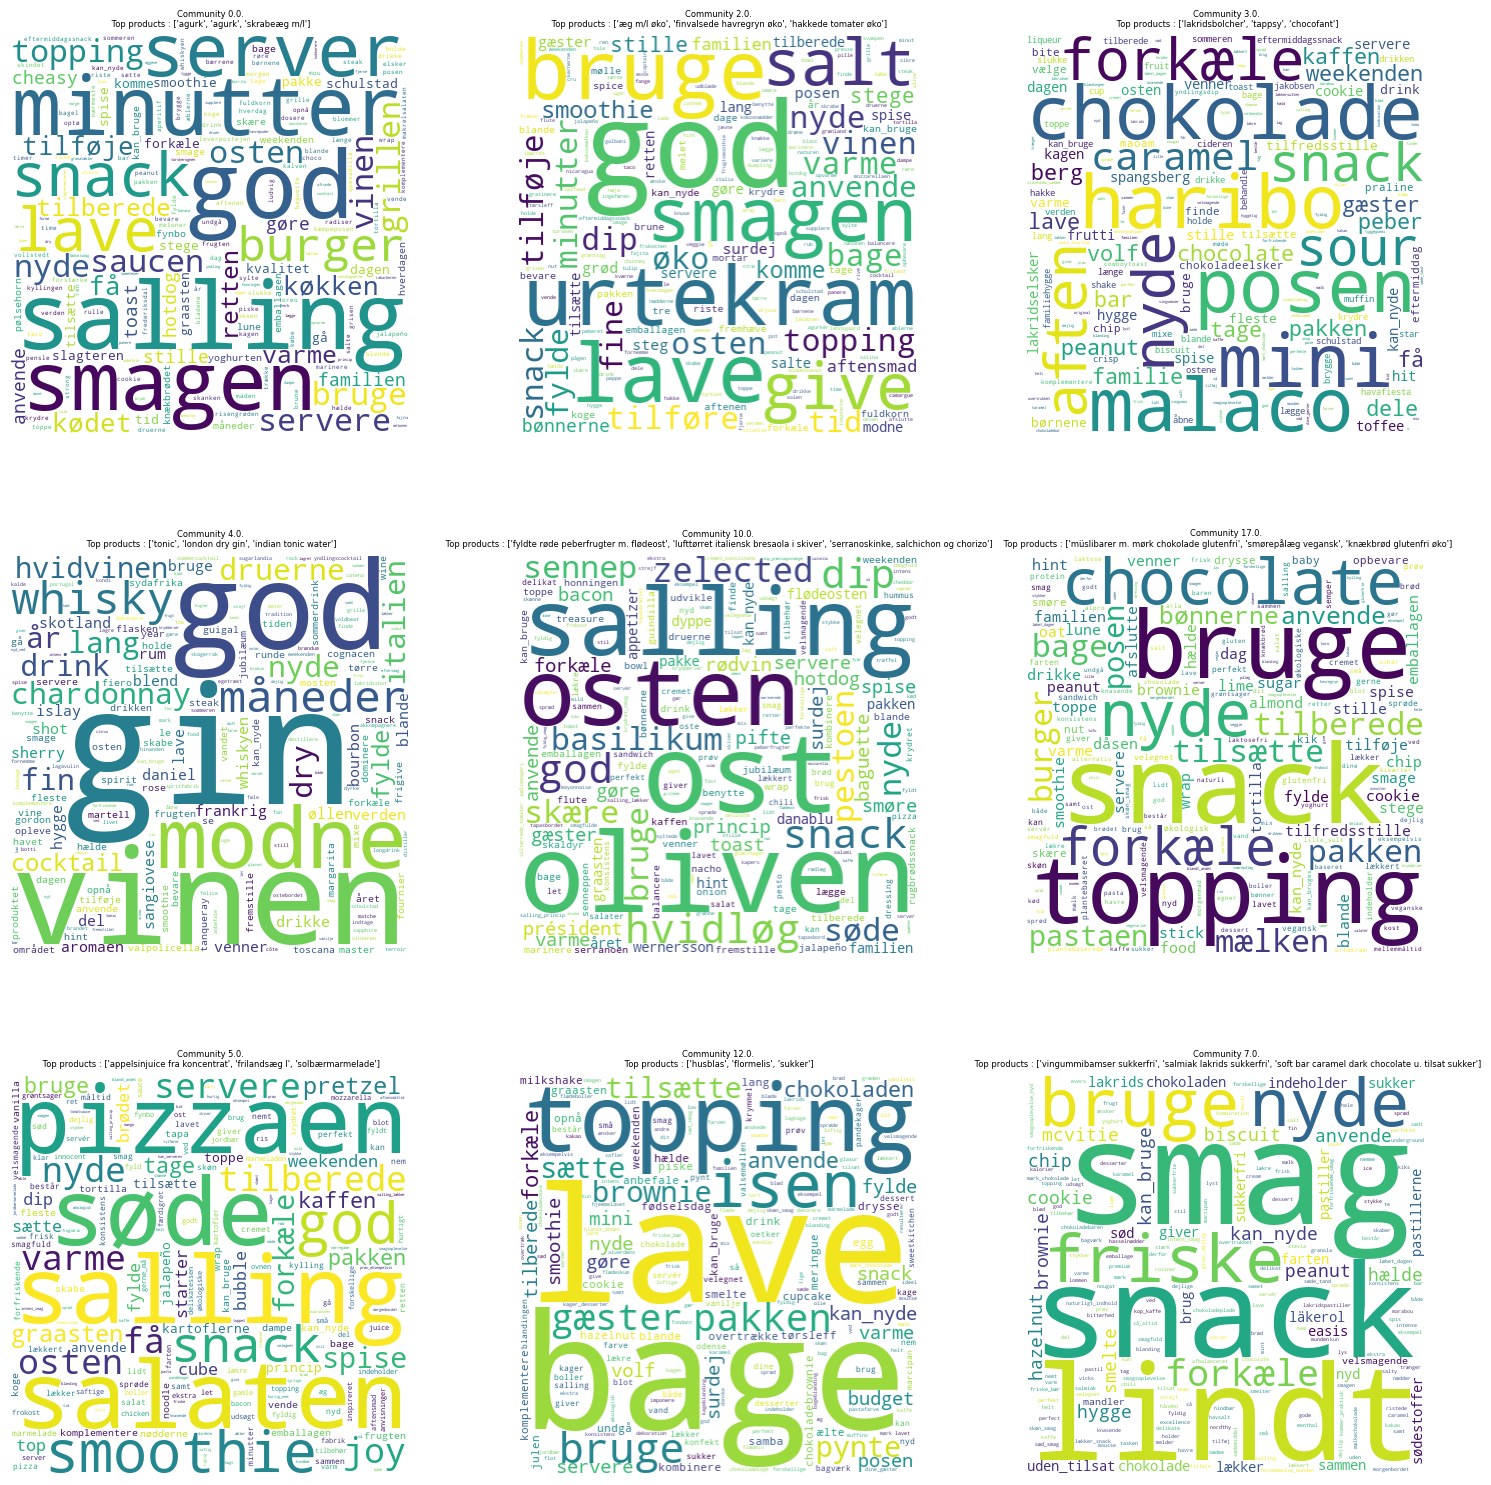

In [110]:
data_product = pd.read_csv('data/df_clean_data_with_comm.csv', sep=";")

top_tfidf_words = {}
Top_com_authors = {}
for c in Top_9_communities:
    Top_com_authors[c] = [list(data_product.loc[data_product['product_id']==top_authors[c][i]].name)[0] for i in range(3)]
    top_tfidf_words[c] = [word[0] for word in sorted(TF_IDF[c].items(), key=lambda x: x[1], reverse=True)] 




# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(16, 16))

# Iterate through each subplot position and community 
for (i, j), c in zip(product(range(3), repeat=2), Top_9_communities):
    data = " ".join(top_tfidf_words[c])
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(data)
   
    axs[i, j].imshow(wordcloud, interpolation='bilinear')
    axs[i, j].set_title(f'Community {c}.\n Top products : {Top_com_authors[c]}',fontsize = 6)
    axs[i, j].axis('off')

# Adjust layout to prevent overlap

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.3)

plt.show()

In [111]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("larskjeldgaard/senda")
model = AutoModelForSequenceClassification.from_pretrained("larskjeldgaard/senda")

# create 'senda' sentiment analysis pipeline 
senda_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

senda_pipeline("Sikke en dejlig dag det er i dag")

/Users/kristofferkjaer/miniconda3/envs/social/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
